In [1]:
import torch
import torch.nn as nn
import torchvision as vision
import torch.nn.functional as F
from torchvision import transforms
from torchvision import datasets
import PIL
import numpy as np
from matplotlib import pyplot as plt
from IPython.core import debugger

In [20]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, filters, kernel_size=3, stride=1, padding=0):
        super(ResidualBlock, self).__init__()
        self.ksize = kernel_size
        self.conv1 = nn.Conv2d(filters, filters, kernel_size, stride, padding)
        self.bn1 = nn.BatchNorm2d(filters)
        self.conv2 = nn.Conv2d(filters, filters, kernel_size, stride, padding)
        self.bn2 = nn.BatchNorm2d(filters)
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += F.pad(residual, (-2, -2, -2, -2))
        return out
                                                 
class UpsampleConvLayer(nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out


In [21]:
class TransformNet(nn.Module):
    
    def __init__(self):
        super(TransformNet, self).__init__()
        
        self.reflectPadding2D = nn.ReflectionPad2d(40)
        self.conv1 = nn.Conv2d(3, 32, 9, padding=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.bn_deconv1 = nn.BatchNorm2d(64)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.bn_deconv2 = nn.BatchNorm2d(32)
        self.outputConv = nn.Conv2d(32, 3, 9, padding=4)
        
        
    def forward(self, x):
        
        x = self.reflectPadding2D(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = F.relu(self.bn_deconv1(self.deconv1(x)))
        x = F.relu(self.bn_deconv2(self.deconv2(x)))
        x = (torch.tanh(self.outputConv(x))+1)*127.5
        
        return x
        

In [22]:
def normalizeTensor(x):
    assert type(x) == torch.Tensor
    minim = torch.min(x)
    maxim = torch.max(x)
    
    return (x - minim)/(maxim - minim)

In [23]:
vgg = vision.models.vgg16(pretrained=True).features

for param in vgg.parameters():
    
    param.requires_grad = False

In [24]:
def normalizeTensor(x):
    assert type(x) == torch.Tensor
    minim = torch.min(x)
    maxim = torch.max(x)
    
    return (x - minim)/(maxim - minim)

In [25]:
vgg = vision.models.vgg16(pretrained=True).features

In [26]:
def VGGRead(path):
    assert type(path) == str
    testimage = PIL.Image.open(path)
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    comptransf = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            normalize,
        ])
    
    testimage = comptransf(testimage)
    
    return testimage.unsqueeze(0)


In [31]:
def gram_matrix(x):
    """
    returns N x C x C gram matrices of N x C x W x H batches
    """
    assert len(x.shape) == 4 #we're working on batches N x C x W x H
    N, C, W, H = x.shape
    
    batch_of_grams = torch.empty((N, C, C))
    
    for idx, batch_item in enumerate(x):
        
        assert batch_item.requires_grad
        
        batch_item = batch_item.reshape(C, W*H)
        
        gram_matrix = torch.matmul(batch_item, batch_item.transpose(0, 1))
        
        batch_of_grams[idx] = gram_matrix
        
    batch_of_grams /= C*W*H
    return batch_of_grams

In [32]:
def get_style_grams(style_image):
    """style_image(string) -> path to Style Image"""
    
    style_image = VGGRead(style_image)
    
    outputs = []
    hooks = []
    def hook(module, input, output):
        outputs.append(output)

    hooks += [vgg[3].register_forward_hook(hook)]
    hooks += [vgg[8].register_forward_hook(hook)]
    hooks += [vgg[15].register_forward_hook(hook)]
    hooks += [vgg[22].register_forward_hook(hook)]
    
    vgg(style_image)
    
    [i.remove() for i in hooks]
    
    relu1_2, relu2_2, relu3_3, relu4_3 = outputs
    
    gram_matrices = {
        'gram1_2' : 0,
        'gram2_2' : 0,
        'gram3_3' : 0,
        'gram4_3' : 0
    }
        
    gram_matrices['gram1_2'] = gram_matrix(relu1_2)[0]
    gram_matrices['gram2_2'] = gram_matrix(relu2_2)[0]
    gram_matrices['gram3_3'] = gram_matrix(relu3_3)[0]
    gram_matrices['gram4_3'] = gram_matrix(relu4_3)[0]
    
    
    return gram_matrices

In [33]:
def loss_function(input_of_net, output_of_net, style_gram_matrices):
    """
        input_of_net: Nx3x256x256 batch of training images
        output_of_net: Nx3x256x256 batch of output images
        style_gram_matrices: dict of style gram matrices
    """
    #First, we need to feed the batches of output to vgg to calculate the style losses
    outputs = []
    hooks = []
    def hook(module, input, output):
        outputs.append(output)

    hooks += [vgg[3].register_forward_hook(hook)]
    hooks += [vgg[8].register_forward_hook(hook)]
    hooks += [vgg[15].register_forward_hook(hook)]
    hooks += [vgg[22].register_forward_hook(hook)]
    
    vgg(output_of_net)
    
    [i.remove() for i in hooks]

    #now outputs is a list of 4 x N x C x W x H
    
    relu1_2, relu2_2, relu3_3, relu4_3 = outputs
    
    gram1_2 = gram_matrix(relu1_2)
    gram2_2 = gram_matrix(relu2_2)
    gram3_3 = gram_matrix(relu3_3)
    gram4_3 = gram_matrix(relu4_3)
    
    style_loss1 = 0.
    style_loss2 = 0.
    style_loss3 = 0.
    style_loss4 = 0.
    
    for i in range(gram1_2.shape[0]):
        
        style_loss1 += torch.norm(gram1_2[i] - style_gram_matrices['gram1_2'])**2
        style_loss2 += torch.norm(gram2_2[i] - style_gram_matrices['gram2_2'])**2
        style_loss3 += torch.norm(gram3_3[i] - style_gram_matrices['gram3_3'])**2
        style_loss4 += torch.norm(gram4_3[i] - style_gram_matrices['gram4_3'])**2
    
    outputs = []
    hooks = []
    def hook(module, input, output):
        outputs.append(output)
        
    hooks += [vgg[15].register_forward_hook(hook)]
    
    vgg(input_of_net)
    
    [i.remove() for i in hooks]

    #now outputs is a list of 4 x N x C x W x H
    
    input_relu3_3 = outputs[0]
    N, C, W, H = input_relu3_3.shape
    feat_loss = 0.
    for i in range(N):
        feat_loss+=(torch.norm(relu3_3[i] - input_relu3_3[i])**2)/C*W*H

    
    return feat_loss+style_loss1+style_loss2+style_loss3+style_loss4
    

In [35]:
net = TransformNet()
style_grams = get_style_grams('jonesy.jpg')
testimage = VGGRead('Cat03.jpg')
n_epochs = 10
batch_size = 25
optimizer = torch.optim.Adam(net.parameters(), amsgrad=True)

for epoch in range(n_epochs):
    
    net.train()
    
    optimizer.zero_grad()
    output = net(testimage)
    loss = loss_function(testimage, output, style_grams)
    loss.backward(retain_graph=True)
    optimizer.step()
        
    print(loss)
        
    print(f"Epoch {epoch} done.")

tensor(209370726400., grad_fn=<ThAddBackward>)
Epoch 0 done.
tensor(81989681152., grad_fn=<ThAddBackward>)
Epoch 1 done.
tensor(35057745920., grad_fn=<ThAddBackward>)
Epoch 2 done.
tensor(17063421952., grad_fn=<ThAddBackward>)
Epoch 3 done.
tensor(7836027904., grad_fn=<ThAddBackward>)
Epoch 4 done.
tensor(4092288512., grad_fn=<ThAddBackward>)
Epoch 5 done.
tensor(2559479552., grad_fn=<ThAddBackward>)
Epoch 6 done.
tensor(1706327040., grad_fn=<ThAddBackward>)
Epoch 7 done.


KeyboardInterrupt: 

In [65]:
res = net(testimage)

In [66]:
resimg = np.array(res[0].permute(1, 2, 0).detach())

In [69]:
resimg = resimg*3

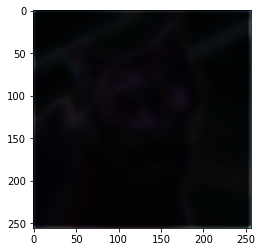

In [70]:
plt.imshow(resimg.astype('uint8'))